# Particle IDs

For some applications, it is useful to keep track of which particle is which, and this can get jumbled up when particles are added or removed from the simulation.  Each particle therefore has a unique ID associated with it.

Let's set up a simple simulation with 10 bodies, and print out all the particles' IDs:

In [1]:
import rebound
import numpy as np

def setupSimulation(Nplanets):
    rebound.reset()
    rebound.integrator = "ias15" # IAS15 is the default integrator, so we don't need this line
    rebound.add(m=1.)
    for i in range(1,Nbodies):
        rebound.add(m=1e-5,x=i,vy=i**(-0.5))
    rebound.move_to_com()

Nbodies=10
setupSimulation(Nbodies)
print([rebound.particles[i].ID for i in range(rebound.N)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


We see that each particle has a unique ID, assigned to it in the order it was added to the simulation, starting from zero.  Now let's do a simple example where we do a short initial integration to isolate the particles that interest us for a longer simulation:

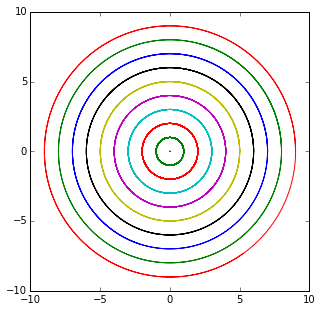

In [2]:
Noutputs = 1000
xs = np.zeros((Nbodies, Noutputs))
ys = np.zeros((Nbodies, Noutputs))
times = np.linspace(0.,50*2.*np.pi, Noutputs, endpoint=False)
for i, time in enumerate(times):
    rebound.integrate(time)
    xs[:,i] = [rebound.particles[j].x for j in range(Nbodies)]
    ys[:,i] = [rebound.particles[j].y for j in range(Nbodies)]
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))
for i in range(Nbodies):
    plt.plot(xs[i,:], ys[i,:])
ax.set_aspect('equal')

At this stage, we might be interested in particles that remained within some semimajor axis range, particles that were in resonance with a particular planet, etc.  Let's imagine a simple (but rather arbitrary) case where we only want to keep particles that had $x > 0$ at the end of the preliminary integration.  For this we can use the `remove_particle` function, passing it the corresponding index in the particles array (note this is not necessarily the same as the particle's ID if you have already removed particles).  

In [3]:
for i in reversed(range(1,Nbodies)):
    if xs[i,-1] < 0:
        rebound.remove_particle(i)

The `remove_particle` function removes the `ith` particle from the particles array, and shifts all particles with higher indices down by 1.  This ensures that the particles array is always sorted in order of increasing ID.  By running through the planets in reverse order above, we are guaranteed that when a particle with index `i` gets removed, the particle replacing it doesn't need to also be removed (we already checked it).  In ascending order, whenever a particle is removed, we would have to check whether the particle replacing it also had to be removed etc.

In [4]:
print("Number of particles after cut = {0}".format(rebound.N))
print("IDs of remaining particles = {0}".format([rebound.particles[j].ID for j in range(rebound.N)]))
print("ID\tx")
for i in range(Nbodies):
    print("{0}\t{1}".format(i, xs[i,-1]))


Number of particles after cut = 5
IDs of remaining particles = [0, 1, 4, 8, 9]
ID	x
0	6.942329259612184e-05
1	0.9540258354392658
2	-1.0427110924854333
3	-2.235604267935961
4	0.07765021611809243
5	-4.91280573550641
6	-4.876031912173703
7	-2.1809553741838963
8	2.0229880089264367
9	5.251115062189657


We see that we removed the appropriate particles, and that the IDs remain ordered.  What you'd do now depends on the application, but we can imagine cases (perhaps if we were instead writing output to a file as particles get removed) where we'd want our output arrays to remain the same size even if particles get removed from the simulation.  In this case, since the IDs are initially assigned starting from zero, we can index the output arrays using the particle IDs:

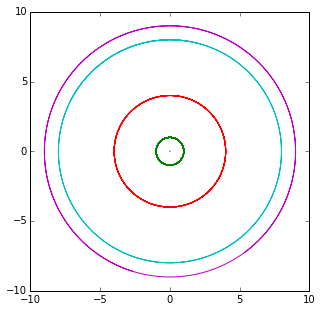

In [5]:
times = np.linspace(50*2*np.pi, 100*2*np.pi,Noutputs)
xs2 = np.zeros((Nbodies, Noutputs))
ys2 = np.zeros((Nbodies, Noutputs))
for i, time in enumerate(times):
    rebound.integrate(time)
    for j in range(rebound.N):
        xs2[rebound.particles[j].ID,i] = rebound.particles[j].x
        ys2[rebound.particles[j].ID,i] = rebound.particles[j].y
%matplotlib inline
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(15,5))
for i in range(rebound.N):
    plt.plot(xs2[rebound.particles[i].ID,:], ys2[rebound.particles[i].ID,:])
ax.set_aspect('equal')

whereas particles that got removed in the cut (e.g., `ID=2`) retain the x and y values they were initialized with:

In [6]:
print(xs2[2,0:10])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
